In [1]:
#import all the csv data
import pandas as pd
from datetime import datetime,timedelta

In [2]:
#open encoded csv data
users = pd.read_csv('takehome_users.csv',encoding="ISO-8859-1", index_col='object_id')

In [3]:
#take a gander at the data
print(users.head())

                 creation_time               name                       email  \
object_id                                                                       
1          2014-04-22 03:53:30     Clausen August    AugustCClausen@yahoo.com   
2          2013-11-15 03:45:04      Poole Matthew      MatthewPoole@gustr.com   
3          2013-03-19 23:14:52  Bottrill Mitchell  MitchellBottrill@gustr.com   
4          2013-05-21 08:09:28    Clausen Nicklas   NicklasSClausen@yahoo.com   
5          2013-01-17 10:14:20          Raw Grace          GraceRaw@yahoo.com   

          creation_source  last_session_creation_time  \
object_id                                               
1            GUEST_INVITE                1.398139e+09   
2              ORG_INVITE                1.396238e+09   
3              ORG_INVITE                1.363735e+09   
4            GUEST_INVITE                1.369210e+09   
5            GUEST_INVITE                1.358850e+09   

           opted_in_to_mailing_l

In [4]:
#open the other csv file
user_engagement = pd.read_csv('takehome_user_engagement.csv',encoding="ISO-8859-1")
user_engagement['time_stamp'] =  pd.to_datetime(user_engagement.time_stamp,format='%Y-%m-%d %X')

In [5]:
print(user_engagement.head(10))

           time_stamp  user_id  visited
0 2014-04-22 03:53:30        1        1
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1
5 2013-12-31 03:45:04        2        1
6 2014-01-08 03:45:04        2        1
7 2014-02-03 03:45:04        2        1
8 2014-02-08 03:45:04        2        1
9 2014-02-09 03:45:04        2        1


In [6]:
#initiate a new dataframe to extract the active data into
UserAdoption = pd.DataFrame(pd.unique(user_engagement.user_id),columns=["user_id"])
UserAdoption['active'] = 0
print(UserAdoption.head())

   user_id  active
0        1       0
1        2       0
2        3       0
3        4       0
4        5       0


In [7]:
#extra active use data (see if each user has logged in 3 times in a 7 day period)
for user, activeStatus in UserAdoption.iterrows():
    #print(user)
    if len(user_engagement[user_engagement.user_id==user])>3:
        minTime_diff = timedelta(days=99)
        tempArray = user_engagement[user_engagement.user_id==user].reset_index()
        for place in range(len(tempArray)-2):
            #print('place: ',place)
            #print(tempArray)
            time_dif = (tempArray.loc[place+2].time_stamp-tempArray.loc[place].time_stamp)
            if (minTime_diff > time_dif):
                minTime_diff = time_dif
        if minTime_diff <= timedelta(days=7):
            UserAdoption.loc[user,'active'] = 1

In [8]:
#show results to double check they make sense
print(UserAdoption.head())
print(len(UserAdoption))
print(UserAdoption.active.sum())

   user_id  active
0        1       0
1        2       0
2        3       1
3        4       0
4        5       0
8823
1199


solve to see if user is active from engagement -> only then merge

In [9]:
#join the data from the 2 csvs
data = users.join(UserAdoption,how='inner')#.set_index('user_id'),how='inner')

In [10]:
print(data.head())

         creation_time               name                       email  \
1  2014-04-22 03:53:30     Clausen August    AugustCClausen@yahoo.com   
2  2013-11-15 03:45:04      Poole Matthew      MatthewPoole@gustr.com   
3  2013-03-19 23:14:52  Bottrill Mitchell  MitchellBottrill@gustr.com   
4  2013-05-21 08:09:28    Clausen Nicklas   NicklasSClausen@yahoo.com   
5  2013-01-17 10:14:20          Raw Grace          GraceRaw@yahoo.com   

  creation_source  last_session_creation_time  opted_in_to_mailing_list  \
1    GUEST_INVITE                1.398139e+09                         1   
2      ORG_INVITE                1.396238e+09                         0   
3      ORG_INVITE                1.363735e+09                         0   
4    GUEST_INVITE                1.369210e+09                         0   
5    GUEST_INVITE                1.358850e+09                         0   

   enabled_for_marketing_drip  org_id  invited_by_user_id  user_id  active  
1                           0    

Use all but name to predict active

need to change formats of these
XXX time-> ints
XXX name-> elim
email-> extract site ->to categorical
creation_source-> to categorical

In [11]:
#extract date infor into a numeric form
data['creation_time'] = pd.to_datetime(data.creation_time,format='%Y-%m-%d %X')
#data['creation_year'] = pd.Series([date.year for date in data['creation_time']])
#data['creation_month'] = pd.Series([date.month for date in data['creation_time']])
#data['creation_day'] = pd.Series([date.day for date in data['creation_time']])
#data['creation_hour'] = pd.Series([date.hour for date in data['creation_time']])
#data['creation_min'] = pd.Series([date.minute for date in data['creation_time']])
#data['creation_sec'] = pd.Series([date.second for date in data['creation_time']])

In [12]:
#get email provider used
import re
def extractEmailSite(email=None):
    if email != None:
        site = re.search('@(.+?)\.', email).group(1)
        return site
    else:
        return None
data['email_site'] = pd.Series([extractEmailSite(email) for email in data['email']])

In [13]:
#transform categorical data into an encoded form
data['email_site_cat'] = data['email_site'].astype("category").cat.codes
data['creation_source_cat'] = data['creation_source'].astype("category").cat.codes

In [14]:
# used https://github.com/naveenrc/RelaxChallenge/blob/master/RelaxChallenge.ipynb as a template to find this feature missing from my model and improve results
data['last_session_creation_time'] = data['last_session_creation_time'].map(lambda data: datetime.\
                                            fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),na_action='ignore')

data['last_session_creation_time'] = pd.to_datetime(data['last_session_creation_time'])

data['total_time_used'] = data['last_session_creation_time'] - data['creation_time']

data = data[data['total_time_used'] >= timedelta(days=0)]

data['total_time_used'] = data['total_time_used'].map(lambda data: data.total_seconds())

In [15]:
#drop all extra columns
encoded_data = data.drop('email_site',axis=1).drop('creation_source',axis=1)\
                   .drop('name',axis=1).drop('creation_time',axis=1)\
                   .drop('email',axis=1)
print(encoded_data.head(7))

   last_session_creation_time  opted_in_to_mailing_list  \
2         2014-03-30 20:45:04                         0   
4         2013-05-22 01:09:28                         0   
5         2013-01-22 02:14:20                         0   
6         2013-12-18 19:37:06                         0   
7         2012-12-20 05:24:32                         0   
10        2014-06-03 15:08:03                         1   
11        2013-12-26 19:55:54                         0   

    enabled_for_marketing_drip  org_id  invited_by_user_id  user_id  active  \
2                            0       1               316.0        3       1   
4                            0       1              5151.0        5       0   
5                            0     193              5240.0        6       0   
6                            0     197             11241.0        7       0   
7                            1      37                 NaN       10       0   
10                           1     318              4

In [16]:
#check form null values
encoded_data.isnull().sum()

last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            1890
user_id                          0
active                           0
email_site_cat                   0
creation_source_cat              0
total_time_used                  0
dtype: int64

In [17]:
#eliminate null values, if no user invite then use id=0
encoded_data['invited_by_user_id'].fillna(0, inplace=True)
#encoded_data['invited_by_user_id'] = encoded_data['invited_by_user_id'].fillna(value = 0)

In [18]:
#check form null values
encoded_data.isnull().sum()

last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
user_id                       0
active                        0
email_site_cat                0
creation_source_cat           0
total_time_used               0
dtype: int64

In [19]:
encoded_data.dropna(axis=0, inplace=True)
encoded_data.isnull().sum()

last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
user_id                       0
active                        0
email_site_cat                0
creation_source_cat           0
total_time_used               0
dtype: int64

In [20]:
#import needed functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [21]:
#print(np.mean(predictions))
print(np.sum(encoded_data.active))

1199


In [22]:
X = encoded_data.drop(['active','last_session_creation_time'],axis=1)
print(X.head())

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
2                         0                           0       1   
4                         0                           0       1   
5                         0                           0     193   
6                         0                           0     197   
7                         0                           1      37   

   invited_by_user_id  user_id  email_site_cat  creation_source_cat  \
2               316.0        3             229                    1   
4              5151.0        5             819                    0   
5              5240.0        6             819                    0   
6             11241.0        7             323                    0   
7                 0.0       10             819                    3   

   total_time_used  
2       11725200.0  
4          61200.0  
5         403200.0  
6         144000.0  
7         316800.0  


In [23]:
#randomly split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,\
    encoded_data.active, \
    test_size=0.33, \
    random_state=42,stratify=encoded_data.active)

#instatiate and train classifier
from sklearn.tree import DecisionTreeClassifier
clf = RandomForestClassifier(n_estimators=10,class_weight='balanced_subsample')#DecisionTreeClassifier()
print(X_train.head())
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)

print('Training Report')
report = classification_report(y_true = np.array(y_train), y_pred = predictions)
print(report)
print('Testing Report')
predictions = clf.predict(X_test)
report = classification_report(y_true = np.array(y_test), y_pred = predictions)
print(report)

      opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
6710                         1                           0     121   
2781                         0                           0     360   
59                           0                           0     325   
7514                         1                           1     279   
4111                         0                           0      37   

      invited_by_user_id  user_id  email_site_cat  creation_source_cat  \
6710                 0.0     9146             222                    3   
2781              9732.0     3780             222                    1   
59                   0.0       77             222                    4   
7514                 0.0    10218             819                    3   
4111                 0.0     5614              96                    3   

      total_time_used  
6710         147600.0  
2781         147600.0  
59          7405200.0  
7514         147600.0  
4111        12

Clearly this model is not great on the testing data but it still should show a couple of the most important features.

Feature ranking:
1. total_time_used (0.807335)
2. user_id (0.056312)
3. org_id (0.054565)
4. invited_by_user_id (0.033425)
5. email_site_cat (0.025504)
6. creation_source_cat (0.012397)
7. opted_in_to_mailing_list (0.006043)
8. enabled_for_marketing_drip (0.004419)


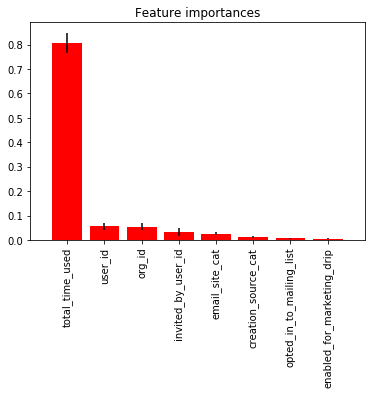

In [24]:
#back calculate which features have the highest predictive importance for retention
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns.values[indices[f]], importances[indices[f]]))
    #print("%d. %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
#plt.xticks(X_train.columns.values, indices)
plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

This shows that the Last session creation time is by far the most important feature. The next is when the account was created and who invited them or if they weren't invited at all. Users of some email sites are more likely to be retained